# Tag Prediction for StackOverflow Posts - Multilabel Classification

We will predict tags for posts from [StackOverflow](https://stackoverflow.com) with linear models.

### Libraries

- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.


### Data
150000 instances in total.
66.67% for model training, 20.00% for cross validation and 13.33% for testing.


### Pipeline
1. Text Normalization
  - Lowercase text
  - Delete special characters excluding '#', '+', '_'
  - Delte stopwords
2. Text Vectorization 
  - BoW
  - Tf-idf
3. One Vs Rest Classifier Training 
  - Logistic Regression
4. Evaluation 
  - Accuracy
  - F1-score
  - AUROC
5. Feature Selection 
6. Parameter Tuning
  - Penalty $c$ by grid searching

### Result
Choose a tf-idf representation
  - Select words that occur in <= 90% of the instances but >= 5 instances.
  - Use unigrams and bigrams
  
Set penalty $c = 10$

### Text Normalization

Three data sets for training, validation and testing.

All corpora contain post titles from StackOverflow and tags (100 tags are available) except for *test*. 

The number of tags for a post is not fixed and could be as many as necessary. Thus, it is a multilabel classification task.

In [1]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from ast import literal_eval
import pandas as pd
import numpy as np

def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

# Import data files and drop rows with missing values
train = read_data('data/train.tsv').dropna()
validation = read_data('data/validation.tsv').dropna()
test = pd.read_csv('data/test.tsv', sep='\t').dropna()

train.head(10)

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]
5,Awesome nested set plugin - how to add new chi...,[ruby-on-rails]
6,How to create map from JSON response in Ruby o...,"[ruby, ruby-on-rails-3, json]"
7,rspec test if method is called,[ruby]
8,SpringBoot Catalina LifeCycle Exception,"[java, spring, spring-mvc]"
9,How to import data from excel to mysql databas...,"[php, codeigniter]"


In [2]:
allSize = len(train) + len(validation) + len(test)
print('There are a total of {:d} instances.\n{:.2f}% for model training,\n{:.2f}% for cross validation and\n{:.2f}% for testing.'
      .format(allSize, len(train)/allSize*100, len(validation)/allSize*100, len(test)/allSize*100))

There are a total of 150000 instances.
66.67% for model training,
20.00% for cross validation and
13.33% for testing.


In [3]:
# Separate features and labels
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

**Task 1 Text Preparation ** 

Normalization

In [4]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        return: modified initial string
    """
    # 1. Lowercase text
    text = text.lower() 
    # 2. Replace '/', '()', '{}', '[]', '|', '@', ',', ';' by space
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    # 3. Delete the non-alphanumerics excluding '#', '+', '_'
    text = BAD_SYMBOLS_RE.sub('',text)
    # 4. Delete stopwords
    text_words = text.split()
    text_words = [t for t in text_words if t not in STOPWORDS]
    text = ' '.join(text_words)
    return text

# First, test it on a small case
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

print(test_text_prepare())

Basic tests are passed.


In [5]:
# Then, test it on a bigger case with 100 sentences
text_prepare_results = pd.read_csv('data/text_prepare_tests.tsv', header = None, sep='\t')
text_prepare_results.rename(columns = {0:'Original'}, inplace = True)
text_prepare_results['Prepared'] = text_prepare_results['Original'].apply(text_prepare)
text_prepare_results

,Original,Prepared
0,SQLite/PHP read-only?,sqlite php readonly
1,Creating Multiple textboxes dynamically,creating multiple textboxes dynamically
2,"that, self or me — which one to prefer in Java...",self one prefer javascript
3,Save PHP date string into MySQL database as ti...,save php date string mysql database timestamp
4,How I can fill my DropDownList with Data from ...,fill dropdownlist data xml file aspnet applica...
5,Programmatically trigger a jQuery-UI draggable...,programmatically trigger jqueryui draggables d...
6,How to get the value of a method argument via ...,get value method argument via reflection java
7,Knockout maping.fromJS for observableArray fro...,knockout mapingfromjs observablearray json obj...
8,"Facebook Connect from Localhost, doing some we...",facebook connect localhost weird stuff
9,fullcalendar prev / next click,fullcalendar prev next click


In [6]:
# Save it to a tsv file to better check if all the texts are successfully processed.
text_prepare_results.to_csv('data/text_prepare_results.tsv', sep='\t')

After testing is finished, we can preprocess the titles in the data sets using function text_prepare.

In [7]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]
X_train[:10]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels',
 'create map json response ruby rails 3',
 'rspec test method called',
 'springboot catalina lifecycle exception',
 'import data excel mysql database using php']

**Task 2 WordsTagsCount ** 

In [8]:
# Compute the occurances of each tag and word in the train corpus, i.e. {'word/tag': frequency}
from collections import defaultdict
tags_counts = defaultdict(int)
words_counts = defaultdict(int)
for labels in y_train:
    for tag in labels:
        tags_counts[tag] += 1
for sent in X_train:
    for word in sent.split():
        words_counts[word] += 1

# Check if all the labels in validation set are all included in the training set
flag = True
for labels in y_val:
    for tag in labels:
        if tag not in tags_counts:
            print('\'\t{}\' is not in the training set. More training data are needed.'.format(tag))
            flag = False
            break
if flag: print('All labels in the validation set are included in the training set.')

All labels in the validation set are included in the training set.


In [9]:
print('There are {:d} classes.\n'.format(len(tags_counts)), list(tags_counts.keys()))

There are 100 classes.
 ['r', 'php', 'mysql', 'c#', 'javascript', 'jquery', 'java', 'ruby-on-rails', 'ruby', 'ruby-on-rails-3', 'json', 'spring', 'spring-mvc', 'codeigniter', 'class', 'html', 'ios', 'c++', 'eclipse', 'python', 'list', 'objective-c', 'swift', 'xaml', 'asp.net', 'wpf', 'multithreading', 'image', 'performance', 'twitter-bootstrap', 'linq', 'xml', 'numpy', 'ajax', 'django', 'laravel', 'android', 'rest', 'asp.net-mvc', 'web-services', 'string', 'excel', 'winforms', 'arrays', 'c', 'sockets', 'osx', 'entity-framework', 'mongodb', 'opencv', 'xcode', 'uitableview', 'algorithm', 'python-2.7', 'angularjs', 'dom', 'swing', '.net', 'vb.net', 'google-maps', 'hibernate', 'wordpress', 'iphone', 'sql', 'visual-studio', 'linux', 'facebook', 'database', 'file', 'generics', 'visual-studio-2010', 'regex', 'html5', 'jsp', 'csv', 'forms', 'validation', 'parsing', 'function', 'pandas', 'sorting', 'qt', 'wcf', 'css', 'date', 'node.js', 'sql-server', 'unit-testing', 'python-3.x', 'loops', 'wind

In [10]:
# Find 3 most popular tags and 3 most popular words in the train data.
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]
print(most_common_tags)
print(most_common_words)

[('javascript', 19078), ('c#', 19077), ('java', 18661)]
[('using', 8278), ('php', 5614), ('java', 5501)]


### Text Vectorization

#### Bag of words

1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Problems:
- Word order is lost.
- Counters are not normalized.

In [11]:
# Set the dictionary size 5000
DICT_SIZE = 5000
# Use train data to find the 5000 most common words
ALL_WORDS = sorted([x for x in words_counts.keys()], key=lambda x: words_counts[x], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {ALL_WORDS[x]: x for x in range(DICT_SIZE)}
INDEX_TO_WORDS = {x: ALL_WORDS[x] for x in range(DICT_SIZE)}

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        words_to_index: a list of words ordered by frequency
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector

# First test it on a small case
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you', 'me too', 'and you are you good']
    answers = [[1, 1, 0, 1], [0, 0, 1, 0], [0, 2, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute). We transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

In [12]:
from scipy import sparse as sp_sparse

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

print('X_train_mybag shape', X_train_mybag.shape)
print('X_val_mybag shape ', X_val_mybag.shape)
print('X_test_mybag shape ', X_test_mybag.shape)

X_train_mybag shape (100000, 5000)
X_val_mybag shape  (30000, 5000)
X_test_mybag shape  (20000, 5000)


In [13]:
# For the 11th row in *X_train_mybag* find how many non-zero elements it has.
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = sum(row != 0)
non_zero_elements_count

7

#### TF-IDF

It extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Some ordering is preserved and word count is normalized, divided by $L2$-norm.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """

    # 1. Create TF-IDF vectorizer with a proper parameters choice
    
    # Filter out too rare words (occur less than in 5 titles) to avoid overfitting
    # and too frequent words (occur more than in 90% of the titles). 
    # Use bigrams along with unigrams.
    # '(\S+)' matches any non-whitespace character
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df = 0.9, min_df = 5, token_pattern = '(\S+)')
    
    # 2. Fit the vectorizer on the train set
    # 3. Transform the train, test, and val sets and return the result
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results, because the performance of future models will drastically depend on it. It takes a couple minutes to train.

In [15]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

# Check if c++ or c# are in our vocabulary, as they are obviously important tokens in our tags prediction task.
tfidf_vocab['c#'], tfidf_vocab['c++']

(1879, 1976)

In [16]:
print('X_train_tfidf shape', X_train_tfidf.shape)
print('X_val_tfidf shape ', X_val_tfidf.shape)
print('X_test_tfidf shape ', X_test_tfidf.shape)

X_train_tfidf shape (100000, 18300)
X_val_tfidf shape  (30000, 18300)
X_test_tfidf shape  (20000, 18300)


### MultiLabel Classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train_bin = mlb.fit_transform(y_train)
y_val_bin = mlb.transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [19]:
def train_classifier(X_train, y_train, c = 1.0):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wrapped into OneVsRestClassifier.
    
    mlb_clf = OneVsRestClassifier(LogisticRegression(C = c))
    mlb_clf.fit(X_train, y_train)
    return mlb_clf

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*. It takes several minutes.

In [20]:
classifier_mybag = train_classifier(X_train_mybag, y_train_bin)
classifier_tfidf = train_classifier(X_train_tfidf, y_train_bin)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [21]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [22]:
y_val_predicted_scores_mybag.shape

(30000, 100)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [23]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val_bin)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

In [24]:
from IPython.display import Latex

### [Evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation)

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).
 The labels predicted for a sample must exactly match the corresponding set of true labels.
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
   * Precision $=\frac{\# \text{ True Positives}}{\# \text{ Predicted Positives}}=\frac{\# \text{ True Positives}}{\# \text{ True Positives}+\# \text{ False Positives}}$, the ability not to label a negative sample as positive.

   * Recall $=\frac{\# \text{ True Positives}}{\# \text{ Actual Positives}}=\frac{\# \text{ True Positives}}{\# \text{ True Positives}+\# \text{ False Negatives}}$, the ablility to find all the positive samples
   * If a classifier has a high precision and high recall, then we are  confident that the algorithm performs well, even if we have very skewed classes.
   * $F_1 = 2\cdot \frac{\text{Precision}\cdot\text{Recall}}{\text{Precision} + \text{Recall}}$
   
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 https://www.medcalc.org/manual/roc-curves.php
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

There are 3 different APIs for evaluating the quality of a model’s predictions:

- Estimator score method: Estimators have a score method providing a default evaluation criterion for the problem they are designed to solve. This is not discussed on this page, but in each estimator’s documentation.
- Scoring parameter: Model-evaluation tools using cross-validation (such as model_selection.cross_val_score and model_selection.GridSearchCV) rely on an internal scoring strategy. This is discussed in the section The scoring parameter: defining model evaluation rules.
- Metric functions: The metrics module implements functions assessing prediction error for specific purposes. These metrics are detailed in sections on Classification metrics, Multilabel ranking metrics, Regression metrics and Clustering metrics.

Finally, Dummy estimators are useful to get a [baseline](https://www.quora.com/What-does-baseline-mean-in-machine-learning#) value of those metrics for random predictions.

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*
 
- 'micro': Calculate metrics globally by considering each element of the label indicator matrix as a label.
- 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- 'weighted': Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

In [26]:
def print_evaluation_scores(y_val, predicted):

    print('Accuracy Score: {:.4f}'.format(accuracy_score(y_val, predicted)))
    print('F1-score macro/micro/weighted: {:.4f}, {:.4f}, {:.4f}'.format(f1_score(y_val, predicted,average='macro'),
          f1_score(y_val, predicted,average='micro'),
          f1_score(y_val, predicted,average='weighted')))
    print('Precision macro/micro/weighted: {:.4f}, {:.4f}, {:.4f}'.format(average_precision_score(y_val,predicted, average='macro'),
          average_precision_score(y_val,predicted, average='micro'),
          average_precision_score(y_val,predicted, average='weighted')))

In [27]:
print('Bag-of-words')
print_evaluation_scores(y_val_bin, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val_bin, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy Score: 0.3580
F1-score macro/micro/weighted: 0.5047, 0.6711, 0.6487
Precision macro/micro/weighted: 0.5617, 0.7085, 0.6976
Tfidf
Accuracy Score: 0.3339
F1-score macro/micro/weighted: 0.4457, 0.6418, 0.6144
Precision macro/micro/weighted: 0.5420, 0.7017, 0.6885


In [28]:
print(classification_report(y_val_bin, y_val_predicted_labels_tfidf, target_names = mlb.classes_))

                    precision    recall  f1-score   support

              .net       0.59      0.07      0.12      1145
              ajax       0.83      0.46      0.59       573
         algorithm       0.82      0.06      0.11       146
           android       0.96      0.52      0.67       898
         angularjs       0.99      0.73      0.84       409
            apache       0.62      0.12      0.21       144
            arrays       0.59      0.32      0.41       640
           asp.net       0.85      0.35      0.49      1150
       asp.net-mvc       0.71      0.25      0.37       381
                 c       0.91      0.45      0.60       976
                c#       0.92      0.64      0.75      5730
               c++       0.92      0.51      0.65      1962
             class       0.45      0.03      0.06       163
       cocoa-touch       0.00      0.00      0.00       148
       codeigniter       0.96      0.74      0.84       211
               css       0.72      0.23

In [29]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.to_csv('data/classification_report.csv', index = False)

report = classification_report(y_val_bin, y_val_predicted_labels_tfidf, target_names = mlb.classes_)
classification_report_csv(report)

You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes
 
ROC Curve: x-axis: FPR, y-axis: TPR for all possible classificaiton thresholds. 
  - True Positive Rate = True Positives / All Positives
  - False Positive Rate = False Positives / All Negatives
 
A classifier that does a very good job separating the classes will have an ROC curve that hugs the upper left corner of the plot. Conversely, a classifier that does poorly will have an ROC curve that is close to the black diagonal line, which represents the accuracy by random guessing.

Area Under the Curve, AUC, is the area under the ROC curve, ranging from 0.5 to 1.0. 

- ROC and AUC are insensitive to whether you predicted probabilities are properly calibrated to actualy represent probabilities of class membership. In other words, ROC and AUC would be identical even if you predicted probabilities ranged from 0.9 to 1 instead of 0 to 1, as long as the ordering of observations by predicted probability remained the same. All the AUC metrics cares about is how well your classifier separated the two classes, and thus it is said to only be sensitive to rank ordering. AUC is the probability that a classifier will rank a radomly chosen positive observation higher than a randomly chosen negative observation. It is a useful metric for datasets with highly unbalanced classes.
- ROC curves can be extended to be problems with three or more classes using One Versus All approach. 
- Choosing a classification threhold is a business decision: minimize false positive rate or maximize true positive rate. For example, set the threshold very low if we are to predict whether a credit card transaction is fraudulent to maximize the true positive rate.

In [30]:
from metrics import roc_auc
%matplotlib inline

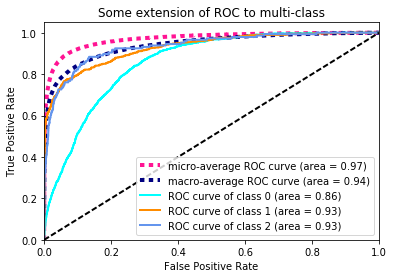

In [31]:
n_classes = len(tags_counts)
roc_auc(y_val_bin, y_val_predicted_scores_mybag, n_classes)

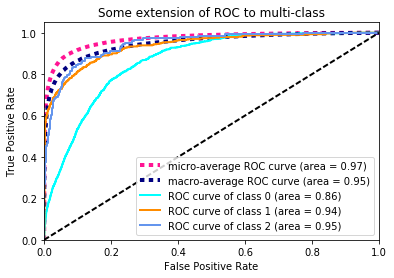

In [32]:
n_classes = len(tags_counts)
roc_auc(y_val_bin, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

Can also use [sklearn.model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to sweep across a range of value of $c$.

In [33]:
for c in [0.1, 1, 10, 100]:
    classifier_mybag = train_classifier(X_train_mybag, y_train_bin, c)
    classifier_tfidf = train_classifier(X_train_tfidf, y_train_bin, c)
    y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
    y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

    y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
    y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

    y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
    y_val_inversed = mlb.inverse_transform(y_val_bin)

    print('c = ', c)
    print('Bag-of-words')
    print_evaluation_scores(y_val_bin, y_val_predicted_labels_mybag)
    print('Tfidf')
    print_evaluation_scores(y_val_bin, y_val_predicted_labels_tfidf)
    print('-' * 40)

c =  0.1
Bag-of-words
Accuracy Score: 0.3113


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-score macro/micro/weighted: 0.4341, 0.6198, 0.5920
Precision macro/micro/weighted: 0.5418, 0.6898, 0.6774
Tfidf
Accuracy Score: 0.1805
F1-score macro/micro/weighted: 0.1408, 0.4322, 0.3922
Precision macro/micro/weighted: 0.4863, 0.6211, 0.6143
----------------------------------------
c =  1
Bag-of-words
Accuracy Score: 0.3580
F1-score macro/micro/weighted: 0.5047, 0.6711, 0.6487
Precision macro/micro/weighted: 0.5617, 0.7085, 0.6976
Tfidf
Accuracy Score: 0.3339
F1-score macro/micro/weighted: 0.4457, 0.6418, 0.6144
Precision macro/micro/weighted: 0.5420, 0.7017, 0.6885
----------------------------------------
c =  10
Bag-of-words
Accuracy Score: 0.3498
F1-score macro/micro/weighted: 0.5079, 0.6683, 0.6515
Precision macro/micro/weighted: 0.5371, 0.6907, 0.6829
Tfidf
Accuracy Score: 0.3631
F1-score macro/micro/weighted: 0.5062, 0.6753, 0.6540
Precision macro/micro/weighted: 0.5581, 0.7042, 0.6939
----------------------------------------
c =  100
Bag-of-words
Accuracy Score: 0.3204
F1-s

In [34]:
# Choose TF-IDF with regularization c = 10
# Train the model with both training and validation data
# Predict on the test data

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df = 0.9, min_df = 5, token_pattern = '(\S+)')
X_train_val_tfidf = tfidf_vectorizer.fit_transform(np.concatenate((X_train, X_val), axis=0))
X_test_tfidf = tfidf_vectorizer.transform(X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vectorizer.vocabulary_.items()} 
y_train_val_bin = mlb.fit_transform(np.concatenate((y_train, y_val), axis = 0))
classifier_tfidf = train_classifier(X_train_val_tfidf, y_train_val_bin, 10)
test_predictions = classifier_tfidf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test['predicted tags'] = test_pred_inversed
test.to_csv('data/test_predictions.tsv', sep='\t')

In [35]:
# Check how many instances don't have labels predicted.
test_unlabeled = test[test['predicted tags'] == ()]
print(len(test_unlabeled), 'instances or {:.2f}% of the test data are unlabeled.'.format(len(test_unlabeled)/len(test)*100))

2858 instances or 14.29% of the test data are unlabeled.


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weights in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [36]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 

    tag_est = classifier.estimators_[tags_classes.index(tag)]
    word_sorted_index = tag_est.coef_.reshape(-1).argsort()
    top_positive_words = [index_to_words[x] for x in word_sorted_index[:-6:-1]] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[x] for x in word_sorted_index[:5]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [37]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, scanf, malloc, fscanf, printf
Top negative words:	php, java, python, javascript, c#

Tag:	c++
Top positive words:	c++, qt, boost, mfc, c++11
Top negative words:	php, java, javascript, python, c#

Tag:	linux
Top positive words:	linux, crosscompiling, signal, killed, glibc
Top negative words:	c#, javascript, aspnet, jquery, nokogiri



In [38]:
for tag in tags_counts:
    print_words_for_tag(classifier_tfidf, tag, mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	r
Top positive words:	r, ggplot2, shiny, ggplot, dplyr
Top negative words:	python, java, php, javascript, c#

Tag:	php
Top positive words:	php, laravel, codeigniter, symfony2, yii
Top negative words:	java, c#, python, aspnet, rails

Tag:	mysql
Top positive words:	mysql, mysqldb, mysql_query, mysql2, database
Top negative words:	sql server, javascript, linq, connection error, select checkbox

Tag:	c#
Top positive words:	c#, wpf, xamarin, unity, linq
Top negative words:	php, java, python, vbnet, spring

Tag:	javascript
Top positive words:	javascript, js, jquery, angular, angularjs
Top negative words:	python, java, c#, c++, swift

Tag:	jquery
Top positive words:	jquery, jqueryajax, jquerys, ajax, jqgrid
Top negative words:	without jquery, python, java, wpf, c#

Tag:	java
Top positive words:	java, spring, hibernate, javafx, jtable
Top negative words:	php, python, c#, rails, c++

Tag:	ruby-on-rails
Top positive words:	rails, devise, paperclip, activeadmin, activerecord
Top negative wor


Tag:	facebook
Top positive words:	facebook, fb, facebooks, oauthexception, friend
Top negative words:	events, cookies, scope, error posting, wall using

Tag:	database
Top positive words:	database, databases, mysqldb, db, pk
Top negative words:	jquery, mapping, mysql database, custom, format

Tag:	file
Top positive words:	file, files, filename, _files, filenames
Top negative words:	excel, utf8, via, call, value

Tag:	generics
Top positive words:	generic, generics, classt, type parameters, parametrized
Top negative words:	python, java c#, javascript, php, warning

Tag:	visual-studio-2010
Top positive words:	vs2010, 2010, mvc using, slices, 2 parameters
Top negative words:	java, php, python, studio 2008, jquery

Tag:	regex
Top positive words:	regex, regexp, regular expression, match, preg_match
Top negative words:	without, jquery remove, rails 4, 1 2, using php

Tag:	html5
Top positive words:	html5, localstorage, canvas, html 5, draganddrop
Top negative words:	alternative, python, c#, c+